In [26]:
import pandas as pd
import numpy as np

#Load all sheets

sheets = pd.read_excel('Regional Sales Dataset.xlsx', sheet_name=None)

df_sales = sheets['Sales Orders']
df_customers = sheets['Customers']
df_products = sheets['Products']
df_regions = sheets['Regions']
df_state_reg = sheets['State Regions']
df_budgets = sheets['2017 Budgets']

In [27]:
#Clean the State Regions sheet

df_state_reg = pd.read_excel('Regional Sales Dataset.xlsx', sheet_name='State Regions', header=None)
df_state_reg.columns = ['state_code', 'state_name', 'region']
df_state_reg = df_state_reg[1:].reset_index(drop=True)

In [28]:
# Merge all the main data

# Merge Sales + Customers
df = df_sales.merge(
    df_customers,
    how='left',
    left_on='Customer Name Index',
    right_on='Customer Index'
)

# Merge + Products
df = df.merge(
    df_products,
    how='left',
    left_on='Product Description Index',
    right_on='Index'
)

# Merge + Regions
# Check what column name is inside df_regions
print("df_regions columns:", df_regions.columns.tolist())
# Usually the ID column is 'ID' or 'id'
if 'id' in df_regions.columns:
    df = df.merge(df_regions, how='left', left_on='Delivery Region Index', right_on='id')
elif 'ID' in df_regions.columns:
    df = df.merge(df_regions, how='left', left_on='Delivery Region Index', right_on='ID')
else:
    print("Could not find ID column in df_regions, check manually!")

#Merge + State Regions

df.columns = df.columns.str.strip().str.lower()
df_state_reg.columns = df_state_reg.columns.str.strip().str.lower()

if 'state_code' in df.columns:
    df = df.merge(df_state_reg, how='left', on='state_code')
elif 'state' in df.columns:
    df = df.merge(df_state_reg, how='left', left_on='state', right_on='state_code')

#Merge + Budgets

df_budgets.columns = df_budgets.columns.str.strip().str.lower()

df_regions columns: ['id', 'name', 'county', 'state_code', 'state', 'type', 'latitude', 'longitude', 'area_code', 'population', 'households', 'median_income', 'land_area', 'water_area', 'time_zone']


In [29]:
# Check available columns in budget sheet
print("df_budgets columns:", df_budgets.columns.tolist())

# Try to rename correctly if needed
if '2017 budgets' in df_budgets.columns:
    df_budgets = df_budgets.rename(columns={'2017 budgets': 'budget_2017'})
elif '2017_budgets' in df_budgets.columns:
    df_budgets = df_budgets.rename(columns={'2017_budgets': 'budget_2017'})

# Find common product column
if 'product name' in df.columns and 'product name' in df_budgets.columns:
    df = df.merge(df_budgets, how='left', on='product name')
elif 'product_name' in df.columns and 'product_name' in df_budgets.columns:
    df = df.merge(df_budgets, how='left', on='product_name')
else:
    print("Check product name column spelling in budget sheet!")

df_budgets columns: ['product name', '2017 budgets']


In [30]:
#Clean + Rename Columns

df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

rename_map = {
    'ordernumber': 'order_number',
    'orderdate': 'order_date',
    'line_total': 'revenue',
    'total_unit_cost': 'cost',
    'latitude': 'lat',
    'longitude': 'lon',
    'budget_2017': 'budget'
}

df = df.rename(columns=rename_map)

In [31]:
#Keep only important columns

cols_to_keep = [
    'order_number', 'order_date', 'customer_names', 'channel',
    'product_name', 'order_quantity', 'unit_price', 'revenue',
    'cost', 'state_name', 'county', 'region', 'lat', 'lon', 'budget'
]

In [32]:
# only keep existing columns
cols_to_keep = [c for c in cols_to_keep if c in df.columns]
df = df[cols_to_keep]

In [33]:
# Handle budgets & profit calculations
# Make sure order_date is datetime
df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')

In [34]:
# Only apply budgets to 2017
df.loc[df['order_date'].dt.year != 2017, 'budget'] = pd.NA

Feature Enginneering

In [35]:
# Calculate total cost and profit
df['total_cost'] = df['order_quantity'] * df['cost']
df['profit'] = df['revenue'] - df['total_cost']
df['profit_margin_pct'] = (df['profit'] / df['revenue']) * 100

# Display final DataFrame
print(df.columns.tolist())
print(df.head())

['order_number', 'order_date', 'customer_names', 'channel', 'product_name', 'order_quantity', 'unit_price', 'revenue', 'cost', 'state_name', 'county', 'region', 'lat', 'lon', 'budget', 'total_cost', 'profit', 'profit_margin_pct']
   order_number order_date    customer_names      channel product_name  \
0   SO - 000225 2014-01-01     Rhynoodle Ltd    Wholesale   Product 27   
1  SO - 0003378 2014-01-01    Thoughtmix Ltd  Distributor   Product 20   
2  SO - 0005126 2014-01-01   Amerisourc Corp    Wholesale   Product 26   
3  SO - 0005614 2014-01-01  Colgate-Pa Group       Export    Product 7   
4  SO - 0005781 2014-01-01     Deseret Group    Wholesale    Product 8   

   order_quantity  unit_price  revenue      cost   state_name  \
0               6      2499.1  14994.6  1824.343      Georgia   
1              11      2351.7  25868.7  1269.918      Indiana   
2               6       978.2   5869.2   684.740   California   
3               7      2338.3  16368.1  1028.852      Indiana   


EDA

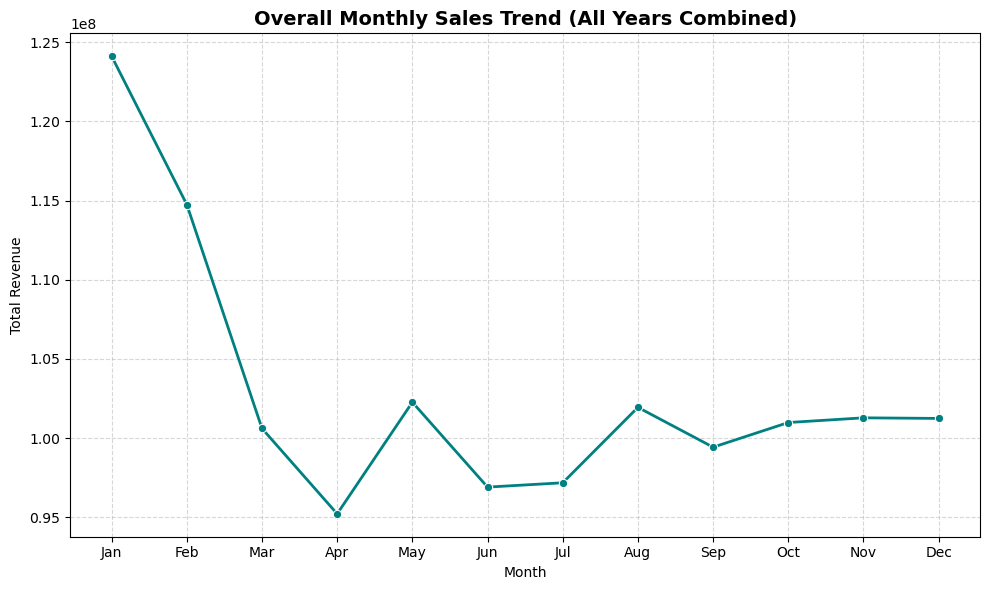

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Convert order_date to datetime (if not already)
df['order_date'] = pd.to_datetime(df['order_date'])
# Extract month name and number
df['month'] = df['order_date'].dt.month
df['month_name'] = df['order_date'].dt.strftime('%b')
# Aggregate total revenue across all years for each calendar month
monthly_sales = (
    df.groupby(['month', 'month_name'])['revenue']
      .sum()
      .reset_index()
      .sort_values('month')
)
# Plot overall monthly sales trend (seasonality)
plt.figure(figsize=(10,6))
sns.lineplot(
    data=monthly_sales,
    x='month_name',
    y='revenue',
    marker='o',
    linewidth=2,
    color='teal'
)
# Styling the chart
plt.title('Overall Monthly Sales Trend (All Years Combined)', fontsize=14, weight='bold')
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

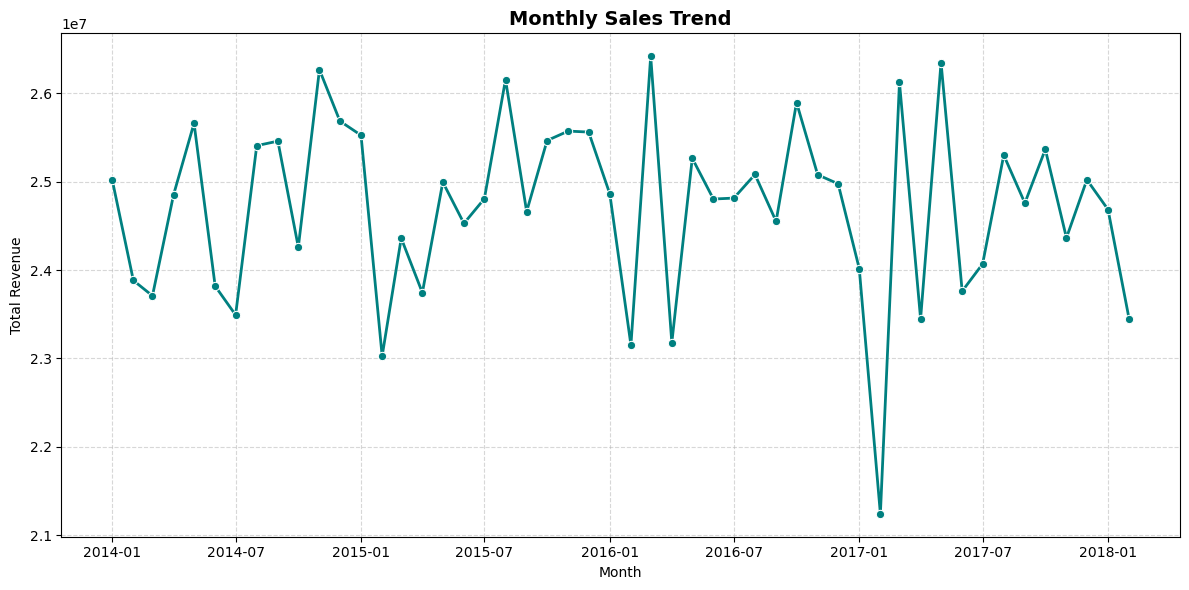

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#Ensure order_date is datetime type 
df['order_date'] = pd.to_datetime(df['order_date'], format='%Y-%m-%d')
#Create 'year_month' column (e.g. 2014-01, 2014-02, etc.) 
df['year_month'] = df['order_date'].dt.to_period('M')
# Group by 'year_month' and sum total revenue for each month 
monthly_sales = (
    df.groupby('year_month')['revenue']
      .sum()
      .reset_index()
)
#Convert period to timestamp for plotting 
monthly_sales['year_month'] = monthly_sales['year_month'].dt.to_timestamp()
#Plot monthly sales trend 
plt.figure(figsize=(12,6))
sns.lineplot(
    data=monthly_sales,
    x='year_month',
    y='revenue',
    marker='o',
    linewidth=2,
    color='teal'
)

#Beautify chart 
plt.title('Monthly Sales Trend', fontsize=14, weight='bold')
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


C:\Users\HP\AppData\Local\Temp\ipykernel_13980\2463036124.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


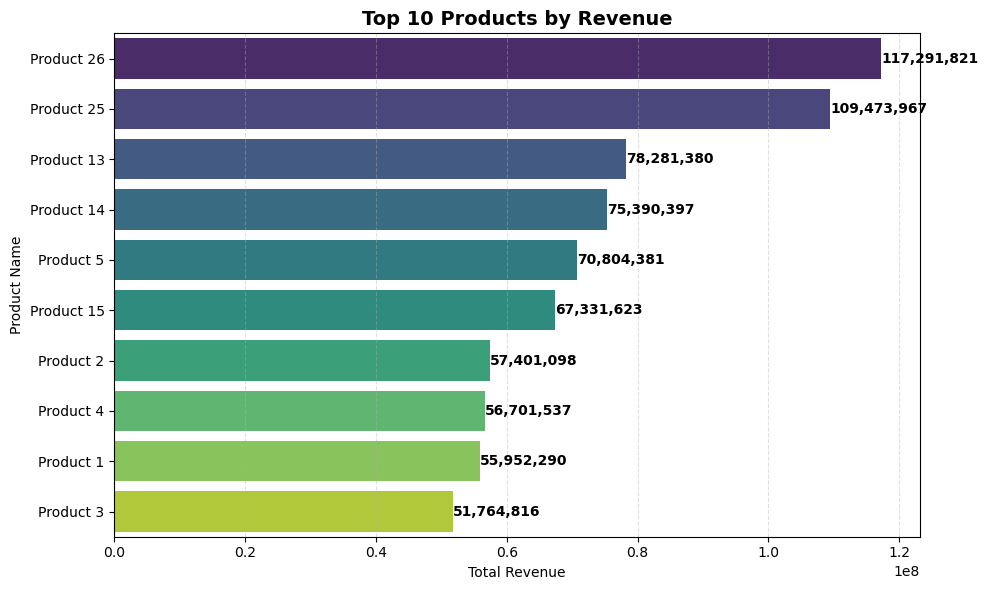

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#Group by product and sum total revenue 
top_products = (
    df.groupby('product_name')['revenue']
      .sum()
      .reset_index()
      .sort_values(by='revenue', ascending=False)
      .head(10)   # take top 10
)
#Plot bar chart
plt.figure(figsize=(10,6))
sns.barplot(
    data=top_products,
    x='revenue',
    y='product_name',
    palette='viridis'
)
for i, value in enumerate(top_products['revenue']):
    plt.text(value, i, f'{value:,.0f}', va='center', ha='left', fontsize=10, color='black', fontweight='bold'
    )
#Beautify chart 
plt.title('Top 10 Products by Revenue', fontsize=14, weight='bold')
plt.xlabel('Total Revenue')
plt.ylabel('Product Name')
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


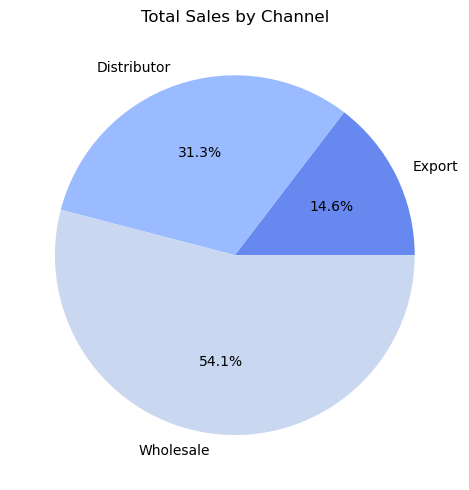

In [39]:
#Sales by channel
chan_sales = df.groupby('channel')['revenue'].sum().sort_values(ascending = True)
plt.figure(figsize = (5,5))
plt.pie(
    chan_sales.values,
    labels = chan_sales.index,
    autopct = '%1.1f%%',
    colors= sns.color_palette('coolwarm')
)
plt.title('Total Sales by Channel')
plt.tight_layout()
plt.show()

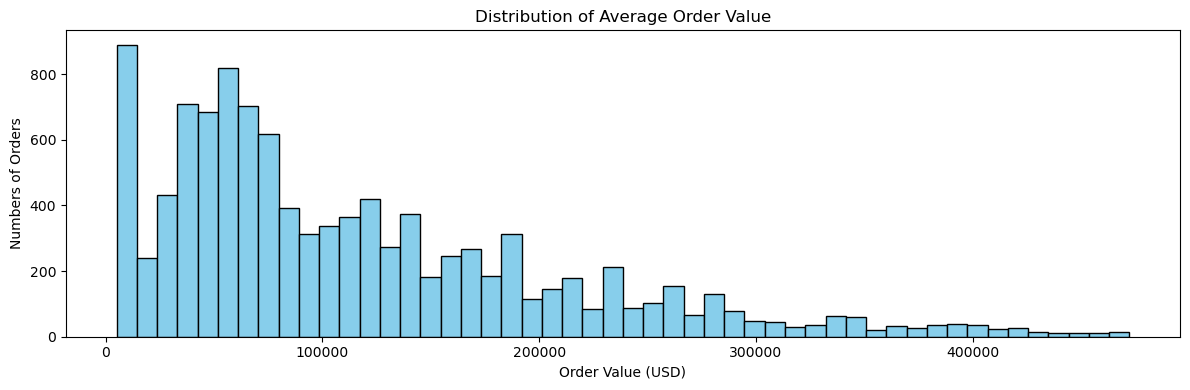

In [40]:
#Average order value Distribution
aov = df.groupby('order_number')['revenue'].sum()
plt.figure(figsize = (12,4))
plt.hist(
    aov,
    bins= 50,
    color = 'skyblue',
    edgecolor = 'black'
)
plt.title('Distribution of Average Order Value')
plt.xlabel('Order Value (USD)')
plt.ylabel('Numbers of Orders')
plt.tight_layout()
plt.show()


C:\Users\HP\AppData\Local\Temp\ipykernel_13980\864302682.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


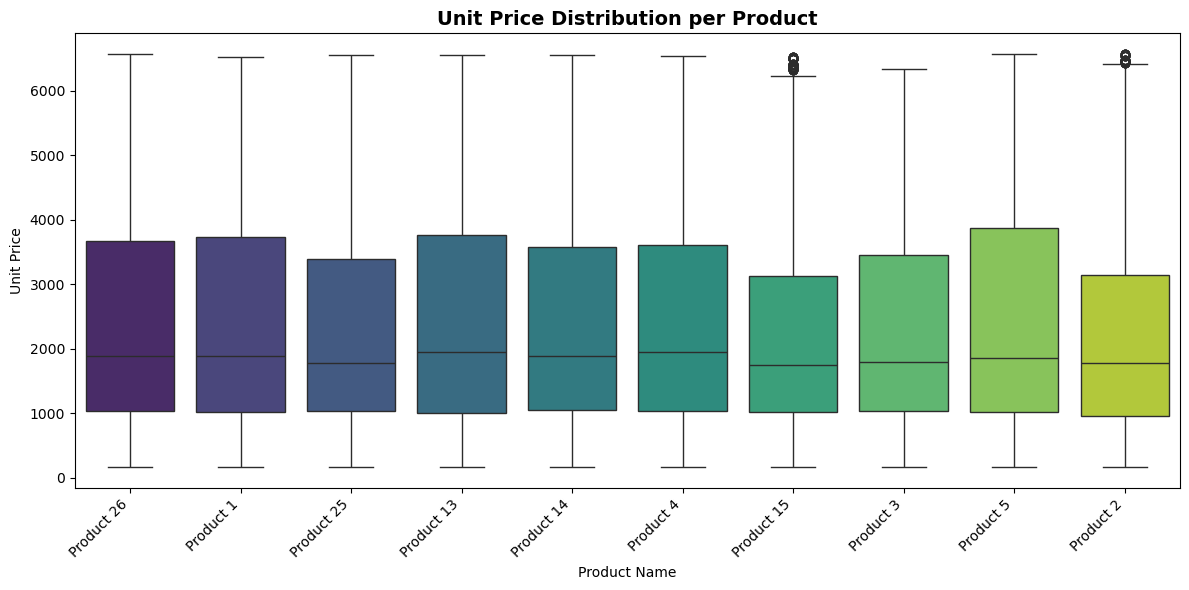

In [41]:
#Unit Price Distribution per Product
import matplotlib.pyplot as plt
import seaborn as sns

# Select top 10 products by number of sales
top_products = df['product_name'].value_counts().head(10).index

# Create the boxplot for unit price distribution
plt.figure(figsize=(12,6))
sns.boxplot(
    data=df[df['product_name'].isin(top_products)],
    x='product_name',
    y='unit_price',      
    palette='viridis'
)

#Beautify the chart
plt.title('Unit Price Distribution per Product', fontsize=14, weight='bold')
plt.xlabel('Product Name')
plt.ylabel('Unit Price')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_13980\3717519015.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


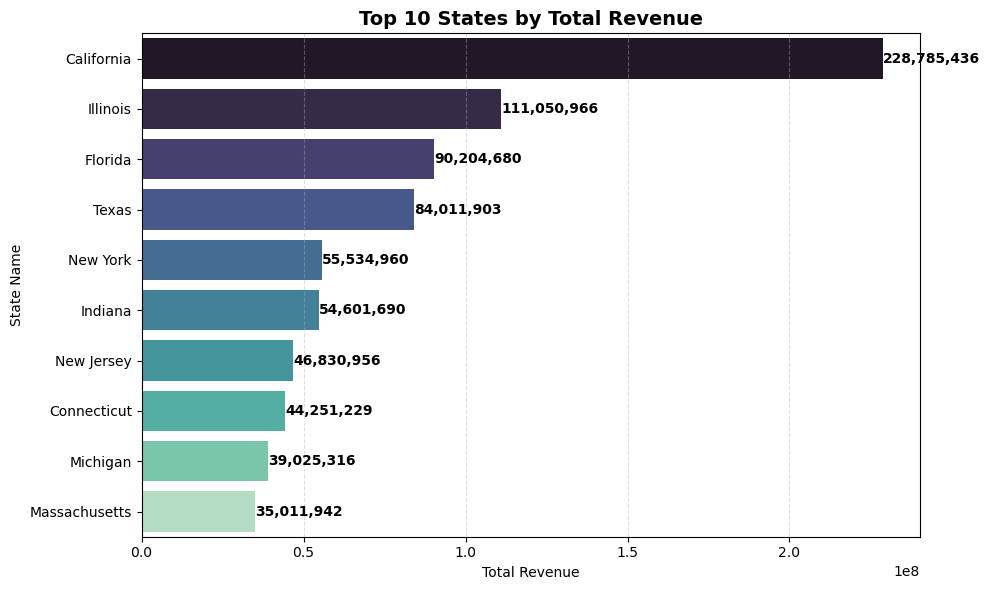

In [42]:
#Top 10 States by Total Revenue
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#Group by state and sum total revenue 
top_states = (
    df.groupby('state_name')['revenue']
      .sum()
      .reset_index()
      .sort_values(by='revenue', ascending=False)
      .head(10)
)

#Plot bar chart
plt.figure(figsize=(10,6))
sns.barplot(
    data=top_states,
    x='revenue',
    y='state_name',
    palette='mako'
)

#Add revenue values beside each bar
for i, value in enumerate(top_states['revenue']):
    plt.text(
        value, i, f'{value:,.0f}',
        va='center', ha='left',
        fontsize=10, color='black', fontweight='bold'
    )

# Beautify the chart 
plt.title('Top 10 States by Total Revenue', fontsize=14, weight='bold')
plt.xlabel('Total Revenue')
plt.ylabel('State Name')
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


C:\Users\HP\AppData\Local\Temp\ipykernel_13980\1358009554.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


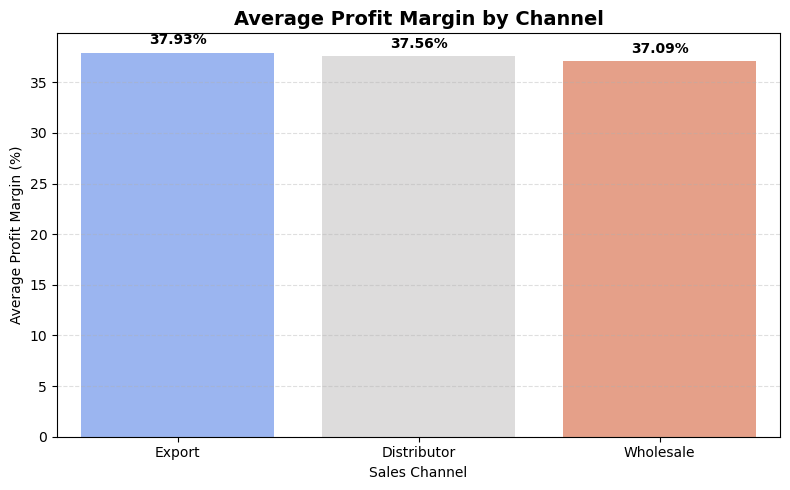

In [43]:
#Average Profit Margin by Channel
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Group by channel and calculate average profit margin 
avg_margin = (
    df.groupby('channel')['profit_margin_pct']
      .mean()
      .reset_index()
      .sort_values(by='profit_margin_pct', ascending=False)
)

# Plot bar chart ---
plt.figure(figsize=(8,5))
sns.barplot(
    data=avg_margin,
    x='channel',
    y='profit_margin_pct',
    palette='coolwarm'
)

# Add value labels above each bar 
for i, value in enumerate(avg_margin['profit_margin_pct']):
    plt.text(
        i, value + 0.5, f'{value:.2f}%',   # +0.5 = small space above the bar
        ha='center', va='bottom', fontsize=10, fontweight='bold'
    )

# Beautify the chart
plt.title('Average Profit Margin by Channel', fontsize=14, weight='bold')
plt.xlabel('Sales Channel')
plt.ylabel('Average Profit Margin (%)')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


C:\Users\HP\AppData\Local\Temp\ipykernel_13980\3938073658.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


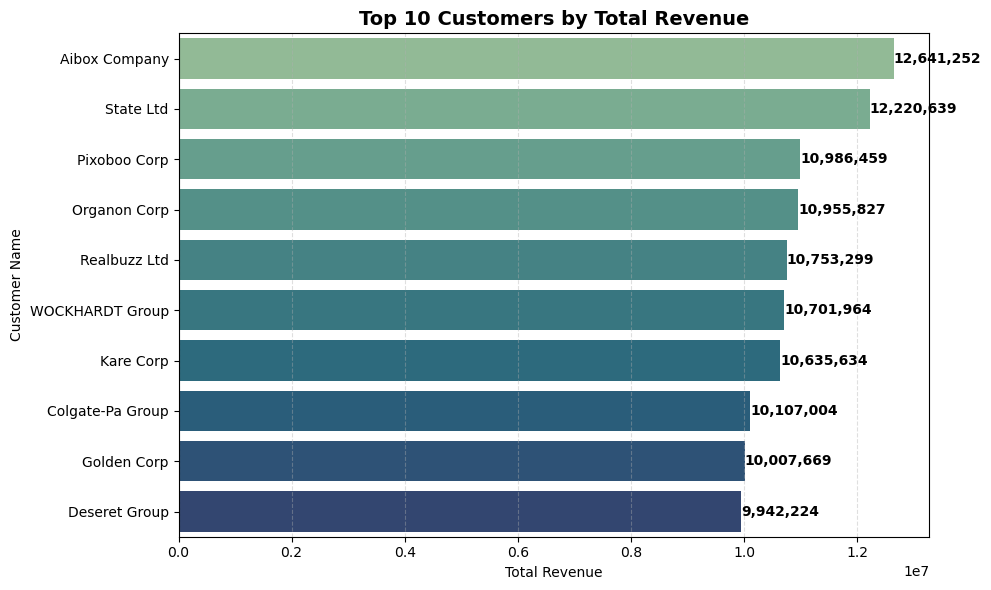

In [44]:
#Top 10 Customers by Total Revenue
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Group by customer and sum revenue 
top_customers = (
    df.groupby('customer_names')['revenue']
      .sum()
      .reset_index()
      .sort_values(by='revenue', ascending=False)
      .head(10)
)

#  Plot bar chart
plt.figure(figsize=(10,6))
sns.barplot(
    data=top_customers,
    x='revenue',
    y='customer_names',
    palette='crest'
)

# Add revenue labels beside each bar 
for i, value in enumerate(top_customers['revenue']):
    plt.text(
        value, i, f'{value:,.0f}',
        va='center', ha='left',
        fontsize=10, fontweight='bold', color='black'
    )

#  Beautify the chart 
plt.title('Top 10 Customers by Total Revenue', fontsize=14, weight='bold')
plt.xlabel('Total Revenue')
plt.ylabel('Customer Name')
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


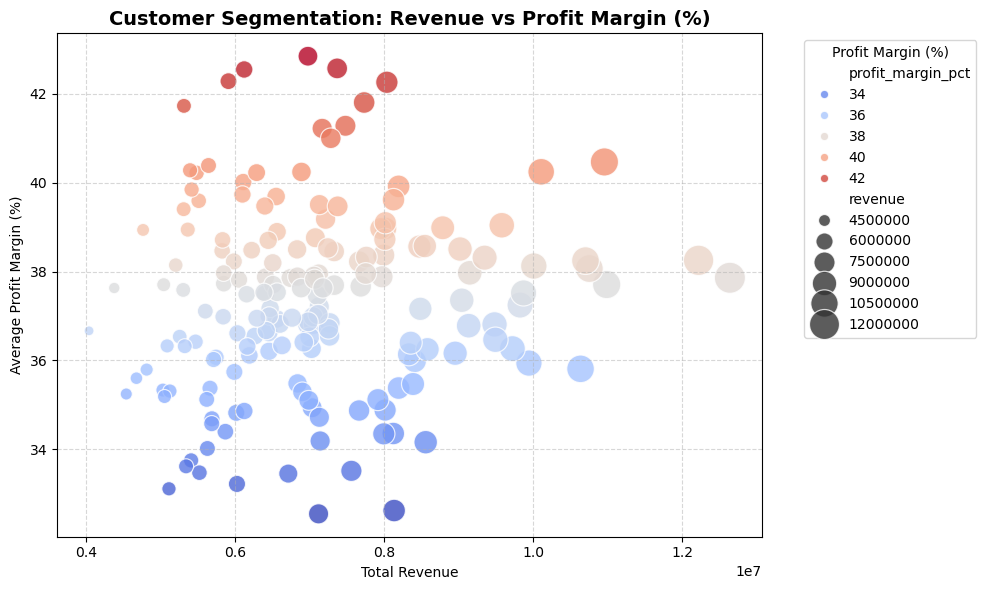

In [45]:
#Customer Segmentation: Revenue vs Profit Marginimport matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#Aggregate data per customer
customer_summary = (
    df.groupby('customer_names')
      .agg({
          'revenue': 'sum',
          'profit_margin_pct': 'mean'
      })
      .reset_index()
)

# Plot scatter plot (Revenue vs Profit Margin %)
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=customer_summary,
    x='revenue',
    y='profit_margin_pct',
    hue='profit_margin_pct',      # color by profit margin
    size='revenue',               # bubble size by revenue
    sizes=(50, 500),
    palette='coolwarm',
    alpha=0.8
)

# Beautify the plot 
plt.title('Customer Segmentation: Revenue vs Profit Margin (%)', fontsize=14, weight='bold')
plt.xlabel('Total Revenue')
plt.ylabel('Average Profit Margin (%)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Profit Margin (%)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


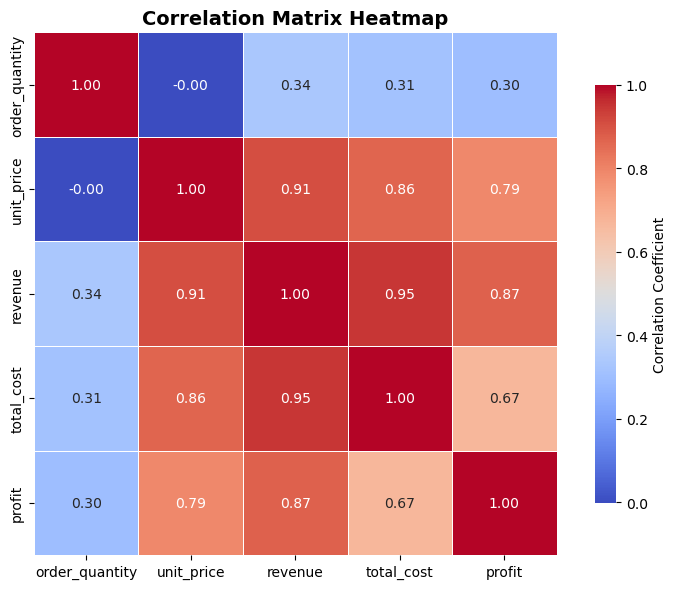

In [46]:
#Correlation Matrix Heatmap
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Select numeric columns for correlation 
corr_cols = ['order_quantity', 'unit_price', 'revenue', 'total_cost', 'profit']
corr_matrix = df[corr_cols].corr()

# Plot heatmap 
plt.figure(figsize=(8,6))
sns.heatmap(
    corr_matrix,
    annot=True,            # show correlation values on cells
    fmt=".2f",             # two decimal places
    cmap='coolwarm',       # color scheme: blue → negative, red → positive
    linewidths=0.5,        # thin lines between cells
    square=True,           # make it a square grid
    cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"}
)

#  Beautify 
plt.title('Correlation Matrix Heatmap', fontsize=14, weight='bold')
plt.tight_layout()
plt.show()


In [47]:
#Channel Distribution: 54% Wholesale, 31% Distribution, 15% Exports

#Monthly Reveriue Cycle: May peaks at x$M

# Top 10 Products (Revenue):

# Bottom 10 Products (Revenue):

In [48]:
# Export Final DataFrame to CSV
df.to_csv('Sales_data(EDA Exported).csv', index=False)